In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import color
from PIL import Image
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

%matplotlib inline

In [4]:
def create_cropped_img(x1, y1, x2, y2, orig_img, i):
    cropped_img = orig_img[y1:y2, x1:x2]
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR)
    # TODO: we need to create folder to dump the images into
    path = "./cropped/img" + str(i) + ".jpg"
    cv2.imwrite(path, cropped_img)
    return

In [10]:
def detect_strawberries(orig_img, img_num):
    hsv_img = color.rgb2hsv(orig_img)

    # Color range for filtering
    lower_thres = np.array([0, 0.204, 0.576])
    upper_thres = np.array([1, 1, 1])

    detected_strawberries = np.logical_and(hsv_img >= lower_thres, hsv_img <= upper_thres).all(axis=2)
    # Convert from boolean to uint8 image
    detected_strawberries = detected_strawberries.astype(np.uint8) * 255

    # Get locations of detected areas
    contours, _ = cv2.findContours(detected_strawberries, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create copy of the original image and draw bounding boxes
    img_with_boxes = orig_img.copy()

    # Filter out areas that aren't big enough to be strawberries
    min_area_thres = 3000

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area_thres:
            x, y, w, h = cv2.boundingRect(contour)
            img_num += 1
            create_cropped_img(x, y, x+h, y+h, orig_img, img_num)
            cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 5)

    return detected_strawberries, img_with_boxes, img_num

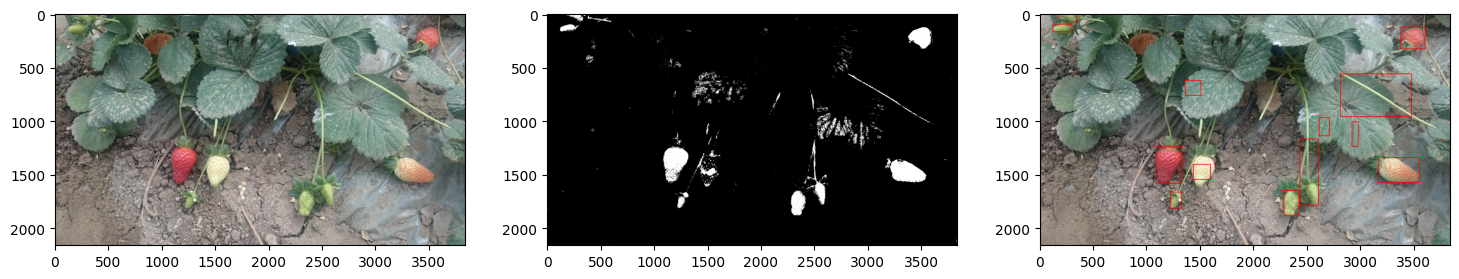

In [12]:
# Input image from website
input_img = "./zoomed_out.jpg"
orig_img = Image.open(input_img)
orig_img = np.asarray(orig_img)

img_num = 0

detected_strawberries, img_with_boxes, img_num = detect_strawberries(orig_img, img_num)

# Display original image, thresholded areas, and image with bounding boxes
fig, (orig, detected, boxes) = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))
orig.imshow(orig_img)
detected.imshow(detected_strawberries, cmap='gray')
boxes.imshow(img_with_boxes)
plt.show()

In [13]:
class StrawberryCNN(nn.Module):
    def __init__(self):
        super(StrawberryCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = StrawberryCNN()

In [14]:
# Function to predict presence of strawberry and display the image
def predict_and_display(image_path, model, stage):

    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = transform(image).unsqueeze(0)

    # Predict presence
    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.round(output).item()

    plt.imshow(image)
    if prediction == 0:
        if stage == 2:
            plt.title("No strawberry detected")
            # Filter out incorrect regions of interest
            os.remove(image_path)
        else:
            plt.title("Ripe")
    else:
        if stage == 2:
            plt.title("Strawberry")
        else:
            plt.title("Unripe")
    plt.axis('off')
    plt.show()

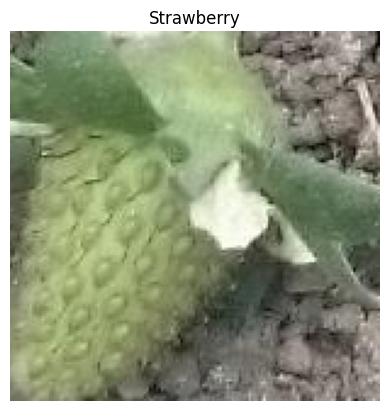

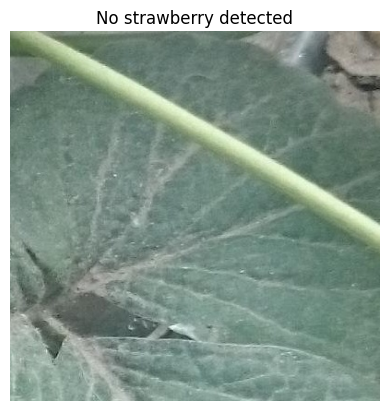

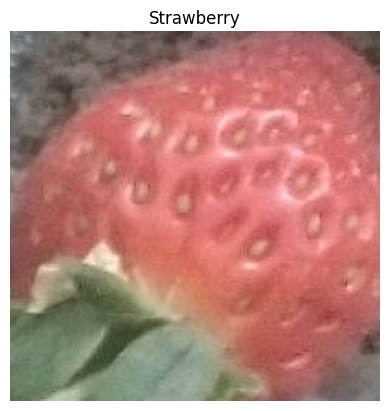

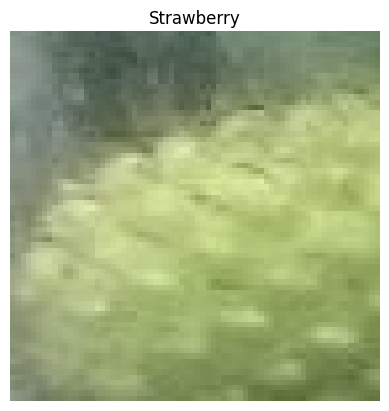

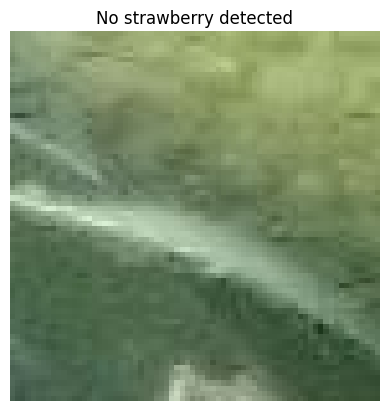

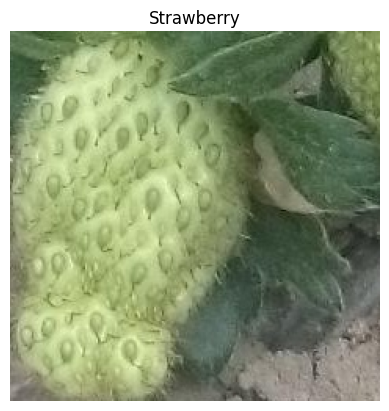

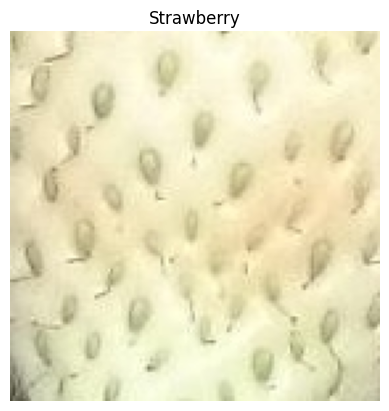

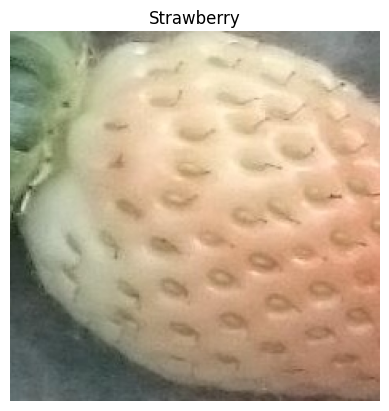

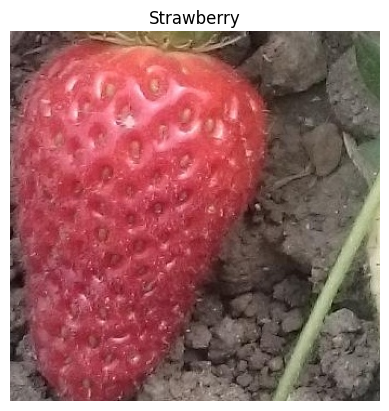

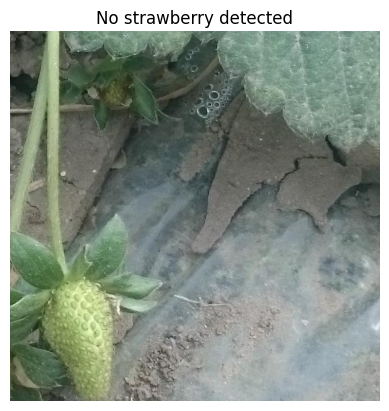

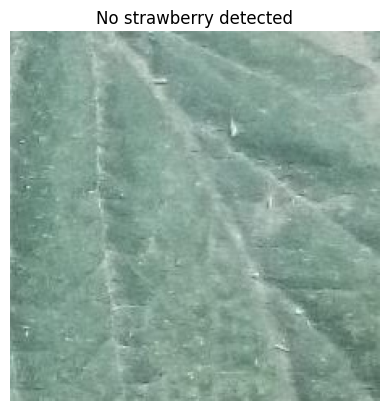

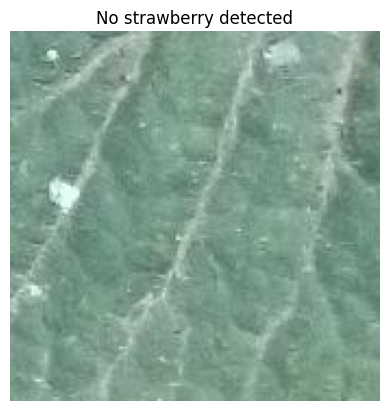

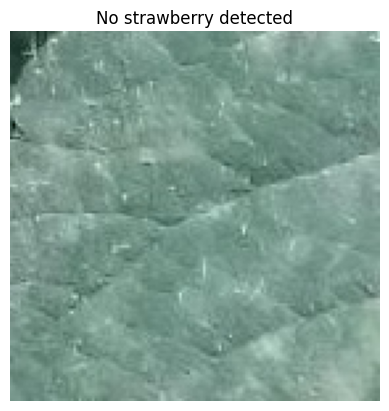

In [17]:
# Iterate through all images in the created directory and filter out incorrect regions of interest
model = StrawberryCNN()
model.load_state_dict(torch.load('strawberry_filter_regions.pth'))
model.eval()

folder_dir = "./cropped/"

img_num = 0
for image in os.listdir(folder_dir):

    img_path = folder_dir + image

    predict_and_display(img_path, model, stage=2)


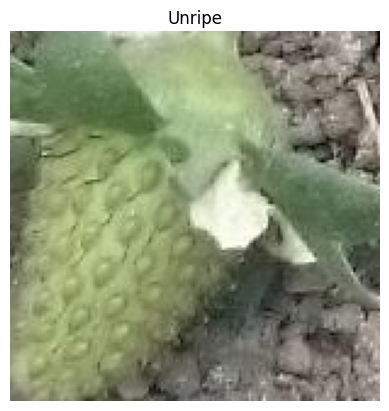

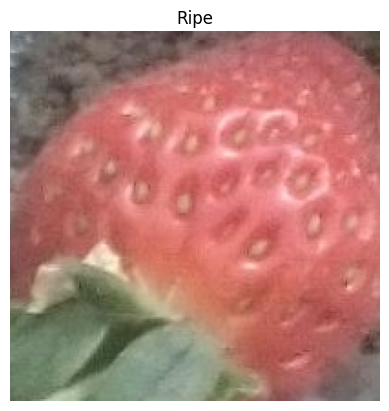

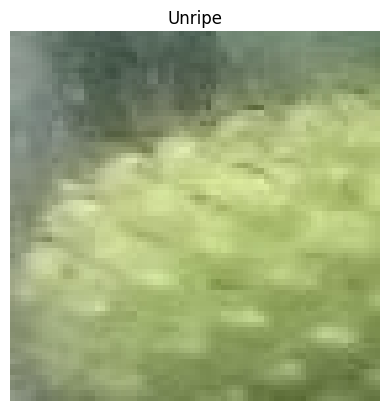

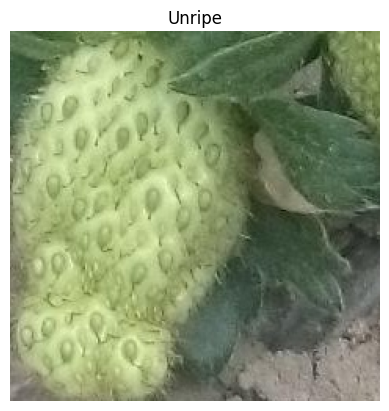

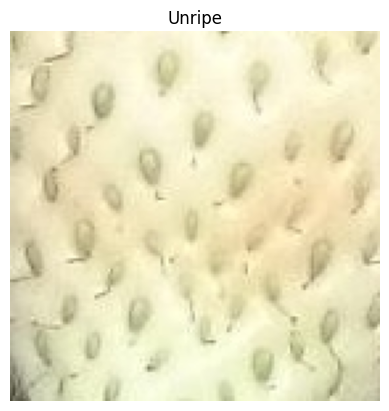

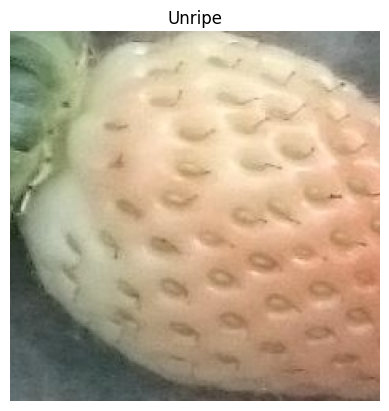

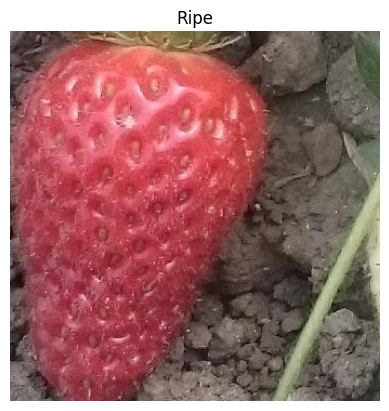

In [18]:
# Iterate through all remaining images and classify the strawberries as ripe/unripe
model = StrawberryCNN()
model.load_state_dict(torch.load('strawberry_classifier.pth'))
model.eval()

folder_dir = "./cropped/"

img_num = 0
for image in os.listdir(folder_dir):

    img_path = folder_dir + image

    predict_and_display(img_path, model, stage=3)
